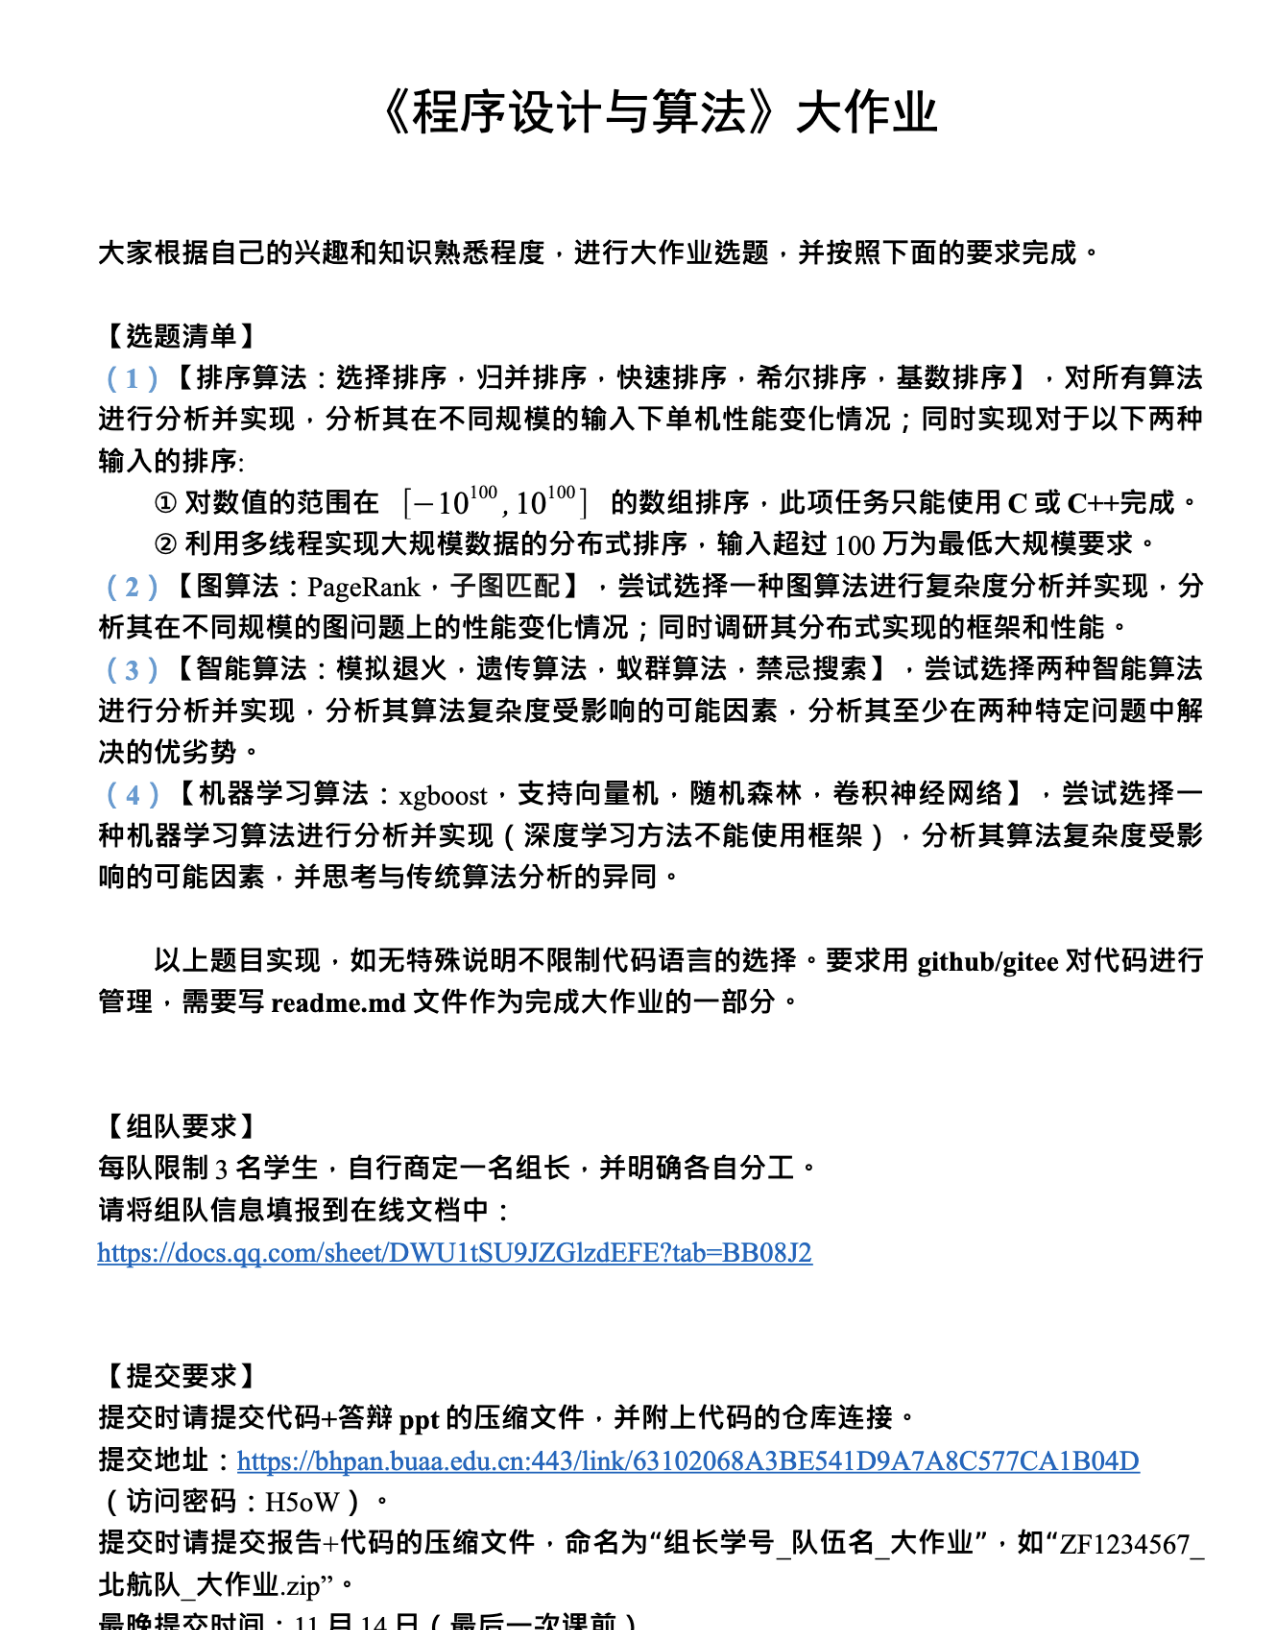

# PageRank 的简化模型

假设一共有 4 个网页 A、B、C、D。它们之间的链接信息如图所示

<img src="https://static001.geekbang.org/resource/image/81/36/814d53ff8d73113631482e71b7c53636.png?wh=1472*1007" alt="img" style="zoom:30%;" />

简单来说，一个网页的影响力 = 所有入链集合的页面的加权影响力之和，用公式表示为：

$$PR(u) =  \sum_{v \in B_u}\frac{PR(v)}{L(v)}\tag{1}$$ 


$u$为待评估的页面，$B_u$ 为页面 $u$ 的入链集合。针对入链集合中的任意页面 $v$，它能给 $u$ 带来的影响力是其自身的影响力 $PR(v)$ 除以 $v$ 页面的出链数量，即页面 $v$ 把影响力 $PR(v)$ 平均分配给了它的出链，这样统计所有能给 $u$ 带来链接的页面 $v$，得到的总和就是网页 $u$ 的影响力，即为 $PR(u)$。

分析A: A的出链是3 分别链接到了B、C、D，那么当用户访问 A 的时候，就有跳转到 B、C 或者 D 的可能性，跳转概率均为 1/3。
分析B: B 有两个出链，链接到了 A 和 D 上，跳转概率为 1/2。
以此类推，就能得出A、B、C、D 这四个网页的转移矩阵 M：
$$
M = \begin{bmatrix}
0 & 1/2 & 1 & 0 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 1/2 & 0 & 0
\end{bmatrix} \tag{2}
$$
假设 A、B、C、D 四个页面的初始影响力都是相同的，即：
$$
W_0 = \begin{bmatrix}
1/4\\
1/4\\
1/4\\
1/4
\end{bmatrix} \tag{3}
$$

当进行第一次转移之后，各页面的影响力$w_1$ 变为：
$$
w_1 = M*w0=\begin{bmatrix}
0 & 1/2 & 1 & 0 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 0 & 0 & 1/2 \\
1/3 & 1/2 & 0 & 0
\end{bmatrix}  \begin{bmatrix}
1/4\\
1/4\\
1/4\\
1/4
\end{bmatrix} = \begin{bmatrix}
9/24\\
5/24\\
5/24\\
5/24
\end{bmatrix} \tag{4}
$$


In [6]:
import numpy as np
M = np.array([[0,0.5,1,0],[0.33,0,0,0.5],[0.33,0,0,0.5],[0.33,0.5,0,0]])
w0=np.array([0.25,0.25,0.25,0.25])
v=np.dot(M,w0)
print(v)

[0.375  0.2075 0.2075 0.2075]



然后我们再用转移矩阵乘以 $w_1$得到 $w_2$ 结果，直到第 $n$ 次迭代后 $w_n$ 影响力不再发生变化，可以收敛到 (0.3333，0.2222，0.2222，0.2222），也就是对应着 A、B、C、D 四个页面最终平衡状态下的影响力。

In [21]:
import numpy as np
M = np.array([[0,0.5,1,0],[1/3,0,0,0.5],[1/3,0,0,0.5],[1/3,0.5,0,0]])
w=np.array([0.25,0.25,0.25,0.25])
for i in range(1000):
    w=np.dot(M,w)
print(w)

[0.33333333 0.22222222 0.22222222 0.22222222]


能看出 A 页面相比于其他页面来说权重更大，也就是 PR 值更高。而 B、C、D 页面的 PR 值相等。

# 简化模型的局限性


## 等级泄露（Rank Leak）


如果一个网页**没有出链**，就像是一个黑洞一样，吸收了其他网页的影响力而不释放，最终会导致其他网页的 PR 值为 0。
<img src="https://static001.geekbang.org/resource/image/77/62/77336108b0233638a35bfd7450438162.png?wh=1190*997" alt="img" style="zoom:30%;" />

## 等级沉没（Rank Sink）

如果一个网页只有出链，**没有入链**（如下图所示），计算的过程迭代下来，会导致这个网页的 PR 值为 0（也就是不存在公式中的 V）。
<img src="https://static001.geekbang.org/resource/image/0d/e6/0d113854fb56116d79efe7f0e0374fe6.png?wh=1203*987" alt="img" style="zoom:30%;" />


# PageRank 的随机浏览模型

> pagerank算法就是通过你的邻居的影响力来评判你的影响力，当然然无法通过邻居来访问你，并不代表你没有影响力，因为可以直接访问你，所以引入阻尼因子的概念。现实生活中，顾客比较多的店铺质量比较好，但是要看看顾客是不是托。

为了解决简化模型中存在的等级泄露和等级沉没的问题，拉里·佩奇提出了 PageRank 的随机浏览模型。他假设了这样一个场景：用户并不都是按照跳转链接的方式来上网，还有一种可能是不论当前处于哪个页面，都有概率访问到其他任意的页面，比如说用户就是要直接输入网址访问其他页面，虽然这个概率比较小。所以他定义了**阻尼因子 d**，这个因子代表了用户按照跳转链接来上网的概率，**通常可以取一个固定值 0.85**，而 1-d=0.15 则代表了用户不是通过跳转链接的方式来访问网页的，比如直接输入网址。


$$PR(u) = \frac{1-d}{N}+ d\sum_{v \in B_u}\frac{PR(v)}{L(v)}\tag{5}$$ 

其中 N 为网页总数，这样我们又可以重新迭代网页的权重计算了，因为加入了阻尼因子 $d$，一定程度上解决了等级泄露和等级沉没的问题。

通过数学定理（这里不进行讲解）也可以证明，最终 PageRank 随机浏览模型是可以收敛的，也就是可以得到一个稳定正常的 PR 值。

# PageRank 应用

网页之间会形成一个**网络**
，是我们的互联网，论文之间也存在着相互引用的关系，可以说我们所处的环境就是各种网络的集合。**只要是有网络的地方，就存在出链和入链**，就会有 PR 权重的计算，也就可以运用我们今天讲的 PageRank 算法。

## 社交领域
在微博上，如果我们想要计算某个人的影响力，该怎么做呢？一个人的微博粉丝数并不一定等于他的实际影响力。如果按照 PageRank 算法，还需要看这些粉丝的质量如何。如果有很多明星或者大 V 关注，那么这个人的影响力一定很高。如果粉丝是通过购买僵尸粉得来的，那么即使粉丝数再多，影响力也不高。


同样，在工作场景中，比如说脉脉这个社交软件，它计算的就是个人在职场的影响力。如果你的工作关系是李开复、江南春这样的名人，那么你的职场影响力一定会很高。反之，如果你是个学生，在职场上被链入的关系比较少的话，职场影响力就会比较低。

同样，如果你想要看一个公司的经营能力，也可以看这家公司都和哪些公司有合作。如果它合作的都是世界 500 强企业，那么这个公司在行业内一定是领导者，如果这个公司的客户都是小客户，即使数量比较多，业内影响力也不一定大。

In [22]:

import networkx as nx
# 创建有向图
G = nx.DiGraph() 
# 有向图之间边的关系
edges = [("A", "B"), ("A", "C"), ("A", "D"), ("B", "A"), ("B", "D"), ("C", "A"), ("D", "B"), ("D", "C")]
for edge in edges:
    G.add_edge(edge[0], edge[1])
pagerank_list = nx.pagerank(G, alpha=1)
print("pagerank值是：", pagerank_list)

pagerank值是： {'A': 0.33333396911621094, 'B': 0.22222201029459634, 'C': 0.22222201029459634, 'D': 0.22222201029459634}


# 分布式实现pagerank
真的的web结构的转移矩阵非常大，目前的网页数量已经超过100亿，转移矩阵是100亿*100亿的矩阵，直接按矩阵乘法的计算方法不可行，需要借助Map-Reduce的计算方式来解决。

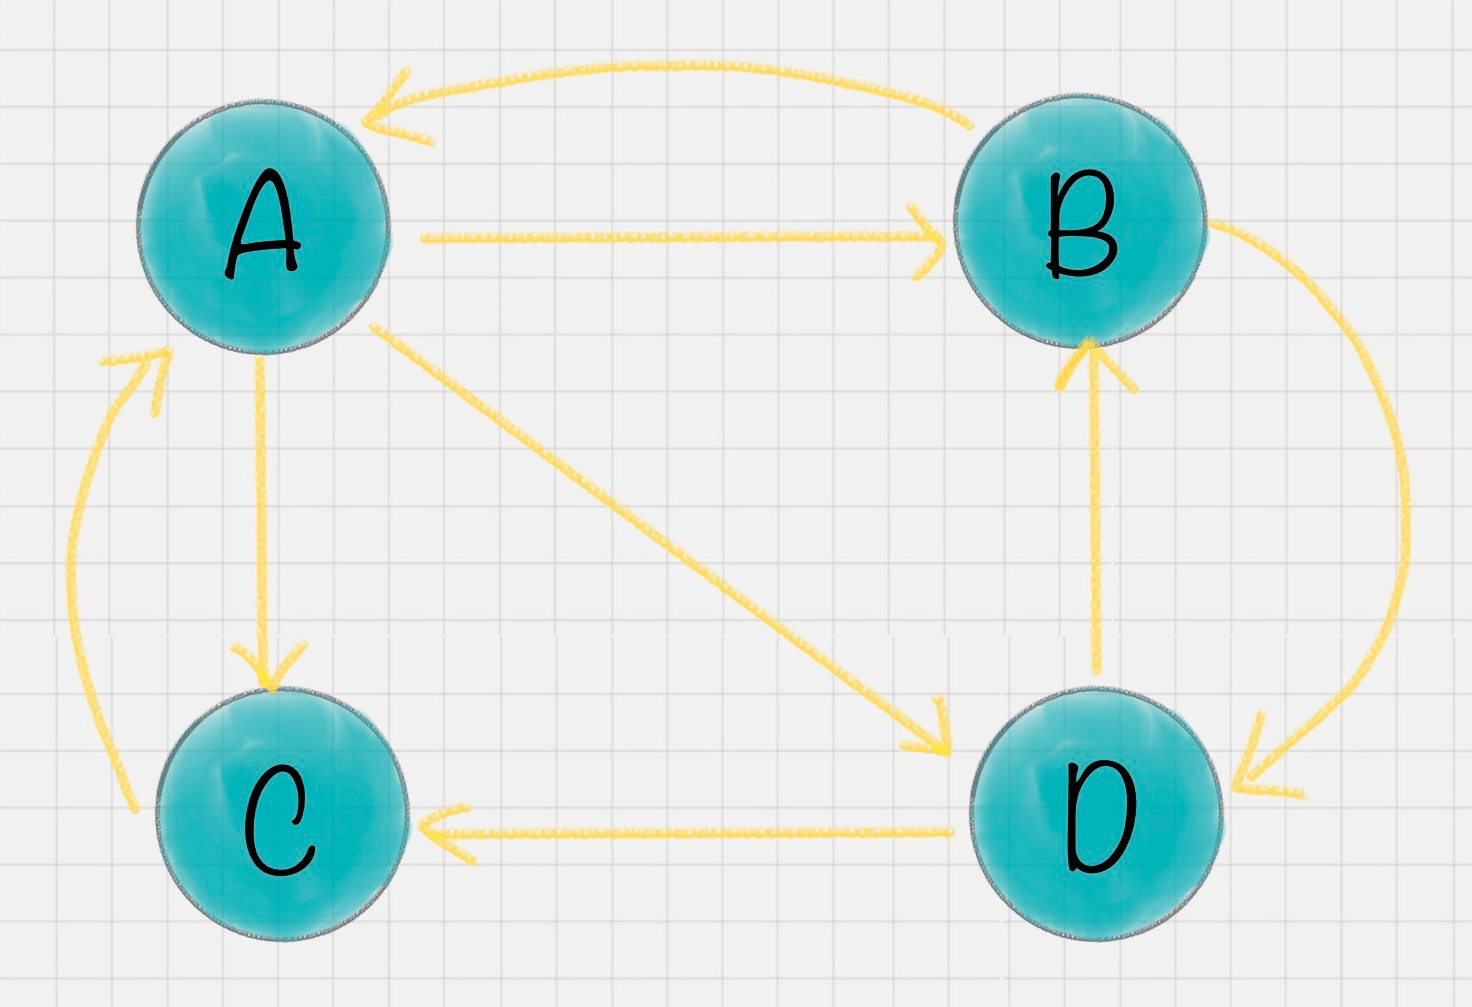
用稀疏矩阵的形式表示图

```
1 A    B    C    D
2 B    A    D
3 C    C
4 D    B    C
```

### 1、map阶段
Map操作的每一行，对所有出链发射当前网页概率值的1/k，k是当前网页的出链数，比如对第一行输出<B，1/3*1/4>,<C，1/3*1/4>,<D，1/3*1/4>;


### 2、Reduce阶段
Reduce操作收集网页id相同的值，累加并按权重计算，pj=a*(p1+p2+...Pm)+(1-a)*1/n，其中m是指向网页j的网页j数，n所有网页数。

流程如下：
进行一次迭代相当于需要两次MapReduce，但第一次的MapReduce只是简单的排序，不需要任何操作。

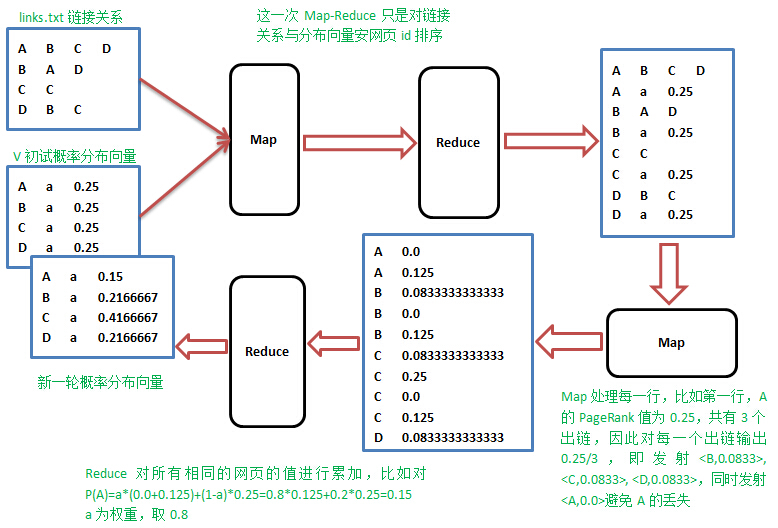

## 分布式计算的原理
分布式计算 (Distributed Computing）采用“分而治之” 的思想，通过将一个较大的问题分割成若干子问题或子任务，然后将这些子问题或子任务，分配到更多独立节点上加以处理，最终把各个节点上产生的中间结果合并得到最终结果

## 分布式计算框架
现有主流的分布式计算框架有 Hadoop、Storm、Spark 等，根据数据的不同特征，选择不同的分布式计算框架进行数据处理。
Hadoop 框架适用于海量的静态数据处理，即所处理的数据都是存储在磁盘中的，同时对计算结果的实时性要求不高，但是要求结果的精确性较高的场景，比如社交网络数据分析、搜索引擎中的广告投放分析等。
Storm 框架适用于实时数据处理，即所处理的是按照一定顺序到达的动态数据，同时计算结果的实时性要求较高，但是结果的精确性可以相应降低的场景，比如日志数据分析等。
Spark 框架适用于交互式数据处理场景，使用内存进行数据计算，并且可以将计算结果实时返回，用户可以根据实时计算结果对计算过程进行控制。
PageRank 算法迭代所使用的为静态存储的数据，对计算结果实时性要求比较低，并且对计算结果精确度要求比较高，所以适合**使用 Hadoop 框架实现 PageRank 算法的分布式计算。**

## MapReduce 编程模型
MapReduce 编程模型是Google 所提出的一项经典的分布式处理技术，其基本思想是：将需要执行的任务的数据划分成若千的块，并将划分的块分配到不同的节点执行Map（映射）操作，最后通过 Reduce（归约）操作将Map操作生成的结果进行汇总。
MapReduce 编程模型执行流程如图：
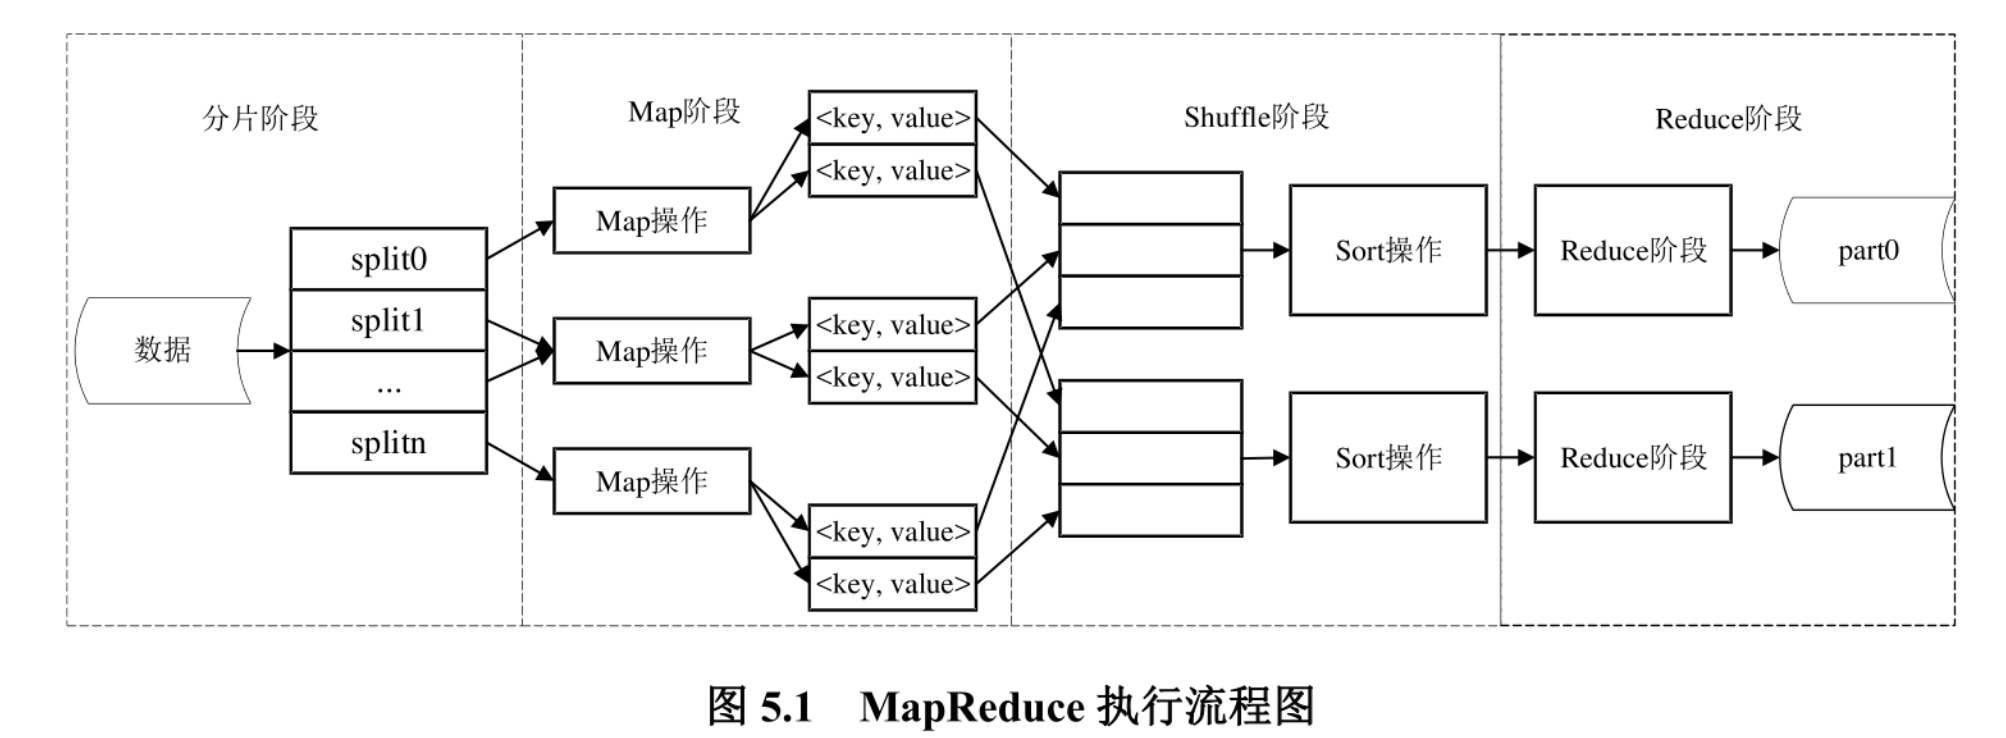

1. 分片阶段：MapReduce 通过待处理数据的信息以及参数配置，将待处理的数据切分成一个个小的切片 （split），然后将切片分配到不同的节点上，将数据根据＜key，value＞的形式输出到Map 阶段。

2. Map 阶段：根据用户编写的map 函数对输入的数据进行处理，并生成新的＜key,ralue＞形式的数据，然后将数据输出到 Shuffle 阶段。
3. Shufle 阶段：Map 阶段输出的＜key，ralue＞分布在不同节点中，shufrle节点则将所有key相同的＜key，ralue＞汇集到同一个节点中，并对同一个节点中的数据根据key 的大小排序，然后将数据输出到 Reduce 阶段。
4. Reduce 阶段：从Shufle 阶段到 Reduce 阶段的过程中，MapReduce会对数据进行整合，将＜key,value＞形式的数据变为＜key,values＞，即将相同key对应的所有value整合为value的集合。然后根据用户自定义的reduce函数对数据进行处理，并将最终结果输出到磁盘。

MapReduce提供了一个并行执行能力高、易于使用的分布式编程模型。将MapReduce模型与分布式系统所结合，通过分布式系统对MapReduce进行任务调度和资源分配，构建一个分布式计算平台已经被应用于各大领域。


## 基于分布式计算平台的PageRank 算法实现
### 分布式计算平台实现 PageRank 算法的问题
通常实现 PageRank 算法时的执行过程是：首先根据网页之间的链接信息构建相应的 web图；根据所构建的 web图，将网页的PR 值分配给它的所有出链网页；然后将网页所获取到的 PR 值累加，并利用阳尼系数对 PR 值进行修正；最后经过多次迭代，直到 PR值收敛。

如果将上述过程直接迁移到分布式计算平台上，其思想就是**将一次 PageRank 算法的迭代转换为一次MapReduce 过程**。

在Map 阶段中，将网页 PR 值分配给它所链出的N 个网页，然后将N 个链出的网页 URL 作为key，所分配的 PR 值作为 value 传递给reduce阶段；

在Reduce 阶段中，将每个网页所获取到的 PR 值累加，并利用阻尼系数d对PR值进行修正。多次迭代则调用多次 MapReduce过程，直到PRs值收敛。


在数据量比较小的时候，直按将 PageRank 算法迁移到分布式平台上是但是随着数据量越来越大，迭代次数越来越多，也会出现如下问题：

1. 表示 URL 的宇符串太长，当处理海量网页时，迭代产生的中间数占空间将是巨大的。（可以用hashMap来解，Url2id）
2. Map 阶段输出到 Reduce 阶段的数据过多，每一个网页都将N条的PR值输出到 Reduce 阶段，导致网络I/0 传输花费大量时间。
3. 在Hadoop 中，Map 的个数要远大于 Reduce 的个数，但是 Map 防数据进行深一步的计算，而是将数据交给了 Reduce 进行整合，导致 Reduce阶段计算时间较长。

### 子图划分

**将 Web 图按照一定规则划分为多个子图，子图内部网页之间链接紧密，且很少有网页链接至别的子图内部的网页，即子图内部呈现出 “高内聚”的特点，子图之间呈现出 “低耦合” 的特点。**

子图内部网页之间的PR 值分配不需要输出到 Reduce 阶段，只有子图之间的PR 值分配才输出到 Reduce 阶段计算。

在划分子图之后，子图内部PR 值的分配和累加工作都交由Map 阶段计算，使Map 阶段承担更多的计算任务，
而子图之间的PR 值分配以及累加交给 Reduce 阶段，减少Reduce 阶段的计算任务。

在Web子图划分时，需要将相互链接紧密的网页划分到同一个子图，所以需要明确
哪一类的网页符合划分条件，而同一个网站内部就满足划分的条件。在同一个网站中，网页之间的链接是十分紧密的，远远大于链接至别的网站的网页。一个网页的 URL 按照条件可以划分为4个等级：Domain、Hlost、Directory 以及Page，下图展示了 URL
的划分情况。
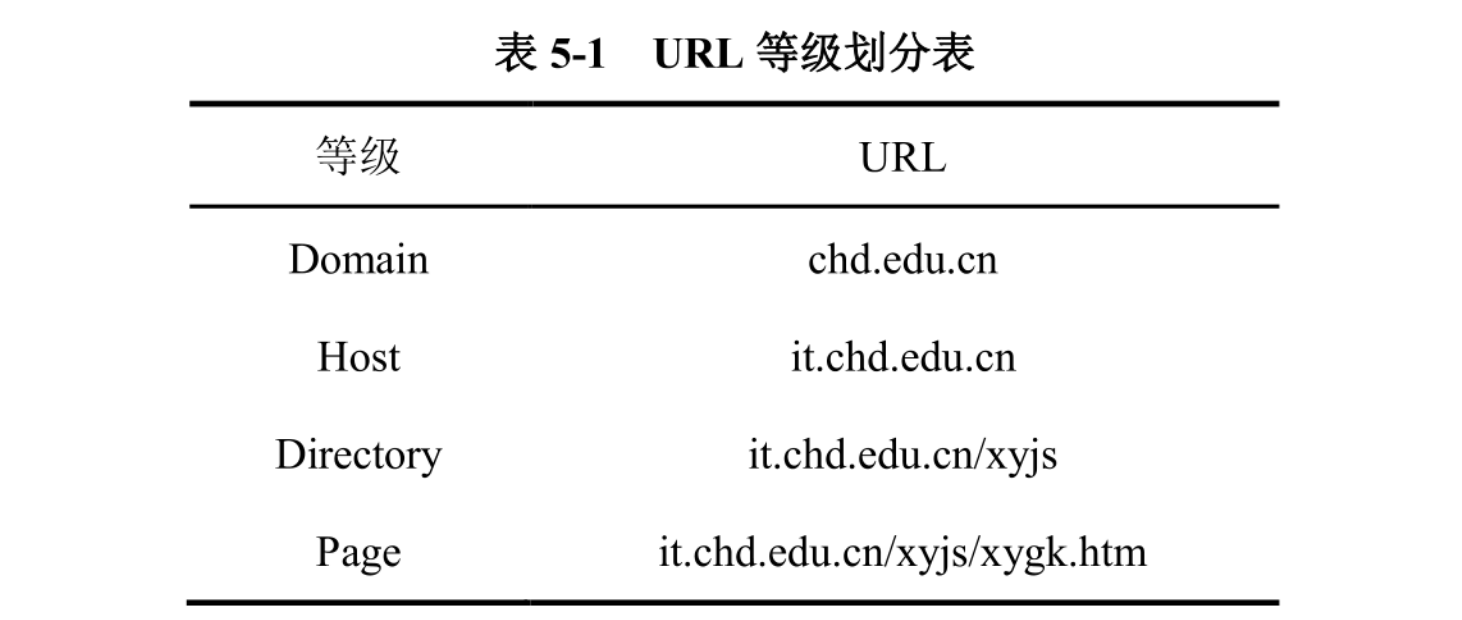
根据不同等级可以划分出不同规模大小的子图，最理想的状态是子图中的 URL 尽可能多且链接尽可能紧密，按照Domain 划分的子图中 URL 相对较多，但是子图内部链接并不是特别紧密。为了得到比较好的划分效果，本文按照 Host 划分
子图，Host 相同的 URL 划分到同一个子图中。
#### 子图划分步骤
通过 Host 划分子图将使用两个 MapReduce过程：第一个MapReduce 过程中，把所获取到的网页出链信息进行格式化为url;outl;ou12;outn 的形式，其中outi 为url所代表的网页的第i个出链；第二个 MapReduce 过程中，Map 阶段的输入为格式化完成的数据，Map 阶段输出的ker为url的 Host,value为url;outl;out2:.outn，然后在 Reduce 阶段将同一个kev(Host）value 整合在一起作为子图，最后 Reduce 输出结果的key为
Host，value 为以Host 所划分的子图，子图中的网页与其出链之间的格式为
url;outl;out2;..outn.



## 参考
[PageRank算法简介及Map-Reduce实现](https://www.cnblogs.com/fengfenggirl/p/pagerank-introduction.html)